In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
###################
# grid dimensions #
###################
NX = 64
LX = 0.3

NY = 64
LY = 0.1

dx = LX / (NX - 1)
dy = LY / (NY - 1)

X = np.array([dx * i for i in range(NX)])
Y = np.array([dy * i for i in range(NY)])

# note that the matrices are indexed as:
# 0-------j
# |
# | 
# i

# while the grid is indexed as
# Y
# | 
# | 
# 0-------X

# The grid defines vertices.

#########################
# ghost grid dimensions #
#########################

# pressure grid is fully staggered from vertices --> DIMENSION(P) = (NY + 1, NX + 1)
# it exists at cell centers, which is one less node in each dimension. But,
# with a ghost border, it is then an extra node in each dimensions
# initial condition would also be set here - intialized as ones for now
# TODO: where's gravity? lol.
p = np.ones(shape=(NY + 1, NX + 1))
p_star = np.ones(shape=(NY + 1, NX + 1))
p_corr = np.ones(shape=(NY + 1, NX + 1))
p_b = np.zeros(shape=(NY + 1, NX + 1))  # used in correction calculation

# u-grid (x-velocity) shares the same vertices as grid in the x-direction
# but is staggered in the y-direction --> DIMENSION(U) = (NY + 1, NX)
# initial condition would also be set here - initialized as zeros for now
# note that row 0 (top) and row NX+1 (bottom) must be zeros, since those are ghost velocities.
u = np.zeros(shape=(NY + 1, NX))
u_star = np.zeros(shape=(NY + 1, NX))
u_corr = np.zeros(shape=(NY + 1, NX))
d_e = np.zeros(shape=(NY + 1, NX))

# v-grid (y-velocity) shares the same vertices as grid in the y-direction
# but is staggered in the x-direction --> DIMENSION(V) = (NY, NX + 1)
# initial condition would also be set here - initialized as zeros for now
# note that col 0 (left) and col NY+1 (right) must be zeros, since those are ghost velocities.
v = np.zeros(shape=(NY, NX + 1))
v_star = np.zeros(shape=(NY, NX + 1))
v_corr = np.zeros(shape=(NY, NX + 1))
d_n = np.zeros(shape=(NY, NX + 1))

#######################
# boundary conditions #
#######################
# -> for a lid driven cavity, the top of the cavity has a velocity
#    in the staggered grid, that is equal to the average of 0 (ghost row) and the first row
U_LID = 2
u[0, :] = U_LID


####################
# fluid properties #
####################
mu = 1  #0.0010518  # dynamic viscosity, Pa*s
rho = 1000 #1000  # density, kg/m^3

###############
# convergence #
###############
# relax factor for velocities
alpha = 0.8  # 0.8
# relax factor for pressure
alpha_p = 0.5  # 0.8

In [17]:
#############################################
# start with a SIMPLE steady state solution #
#############################################

itr = 0
error = 1
ethresh = 10**-4  # error in continuity

# track iterations
errors = []

# solution loop
while error > ethresh:
    # u momo eqn -> interior
    for i in range(1, NY):
        for j in range(1, NX - 1):
            # interpolate at facecs of u velocity control volume to get velocities
            u_E = (u[i, j] + u[i, j + 1]) / 2
            u_W = (u[i, j] + u[i, j - 1]) / 2
            # v velocity grid is offset relative to u velocity grid
            v_N = (v[i - 1, j] + v[i - 1, j + 1]) / 2
            v_S = (v[i, j] + v[i, j + 1]) / 2

            # u momo eqn coefficients
            a_E = -(u_E / 2) * dy + (mu / rho) * (dy / dx)
            a_W = (u_W / 2) * dy + (mu / rho) * (dy / dx)
            a_N = -(v_N / 2) * dx + (mu / rho) * (dx / dy)
            a_S = (v_S / 2) * dx + (mu / rho) * (dx / dy)

            a_e = (u_E / 2) * dy - (u_W / 2) * dy + (v_N / 2) * dx - (v_S / 2) * dx
            a_e += (mu / rho) * ((1 / dy + 1 / dy) * dx + (1 / dx + 1 / dx) * dy)

            A_e = -dy / rho

            # store d_e for pressure correction
            d_e[i, j] = A_e / a_e

            # calculate uncorrected velocity
            u_star[i, j] = (
                a_E * u[i, j + 1] + a_W * u[i, j - 1] + a_N * u[i - 1, j] + a_S * u[i + 1, j]
            ) / a_e + d_e[i, j] * (p[i, j + 1] - p[i, j])


    # u momo eqn -> boundary
    # top -> average of first two rows must be the lid condition
    u_star[0, :] = U_LID * 2 - u_star[1, :]  # TODO is this right?
    # bottom -> average of last two rows must be zero
    u_star[NY, :] = -u_star[NY - 1, :]
    # left -> zero. do not overwrite previously assigned values
    u_star[1:NY, 0] = 0
    # right
    u_star[1:NY, NX - 1] = 0

    # v momo eqn -> interior
    for i in range(1, NY - 1):
        for j in range(1, NX):
            # interpolate at facecs of v velocity control volume to get velocities
            # u velocity grid is offset relative to v velocity grid
            u_E = (u[i, j] + u[i + 1, j]) / 2
            u_W = (u[i, j - 1] + u[i + 1, j - 1]) / 2
            v_N = (v[i - 1, j] + v[i, j]) / 2
            v_S = (v[i + 1, j] + v[i, j]) / 2

            # v momo eqn coefficients
            a_E = -(u_E / 2) * dy + (mu / rho) * (dy / dx)
            a_W = (u_W / 2) * dy + (mu / rho) * (dy / dx)
            a_N = -(v_N / 2) * dx + (mu / rho) * (dx / dy)
            a_S = (v_S / 2) * dx + (mu / rho) * (dx / dy)

            a_n = (u_E / 2) * dy - (u_W / 2) * dy + (v_N / 2) * dx - (v_S / 2) * dx
            a_n += (mu / rho) * ((1 / dx + 1 / dx) * dy + (1 / dy + 1 / dy) * dx)

            A_n = -dx / rho

            # store d_n for pressure correction
            d_n[i, j] = A_n / a_n

            # calculate uncorrected velocity
            v_star[i, j] = (
                a_E * v[i, j + 1] + a_W * v[i, j - 1] + a_N * v[i - 1, j] + a_S * v[i + 1, j] 
            ) / a_n + d_n[i,j] * (p[i, j] - p[i + 1, j])

    
    # v momo eqn -> boundary
    # left -> ensure average of leftmost two columns is 0
    v_star[:, 0] = -v_star[:, 1]
    # right -> ensure average of rightmost two columns is 0
    v_star[:, NX] = -v_star[:, NX - 1]
    # top -> zero. do not overwrite previously assigned values
    v_star[0, 1:NX] = 0
    # bottom -> zero. do not overwrite previously assigned values
    v_star[NY - 1, 1:NX] = 0

    # reset pressure corrections to zero
    p_corr[:, :] = 0
    p_b[:, :] = 0

    # loop over interior of pressure field to calculate pressure corrections
    for i in range(1, NY):
        for j in range(1, NX):
            a_E = -d_e[i, j] * dy
            a_W = -d_e[i, j - 1] * dy
            a_N = -d_n[i - 1, j] * dx
            a_S = -d_n[i, j] * dx

            a_P = a_E + a_W + a_N + a_S

            p_b[i, j] = -(u_star[i, j]  - u_star[i, j - 1]) * dy - (v_star[i - 1, j] - v_star[i, j]) * dx
            #print(p_b[i,j])

            p_corr[i, j] = a_E * p_corr[i, j + 1] + a_W * p_corr[i, j - 1] + a_N * p_corr[i - 1, j] + a_S * p_corr[i + 1, j]
            p_corr[i, j] += p_b[i, j]
            p_corr[i, j] /= a_P
    
    # apply pressure corrections
    for i in range(1, NY):
        for j in range(1, NX):
            p[i, j] += alpha_p * p_corr[i, j]
    
    # enforce no pressure gradient across physical boundaries
    # top
    p[0, :] = p[1, :]
    # bottom
    p[NY, :] = p[NY - 1, :]
    # left
    p[:, 0] = p[:, 1]
    # right
    p[:, NX] = p[:, NX - 1]

    # correct the u velocity field
    # interior
    for i in range(1, NY):
        for j in range(1, NX - 1):
            u[i, j] = u_star[i, j] + alpha * d_e[i, j] * (p_corr[i, j + 1] - p_corr[i, j])
    
    # boundary
    # top -> average of first two rows must be the lid condition
    u[0, :] = U_LID * 2 - u[1, :]  # TODO is this right?
    # bottom -> average of last two rows must be zero
    u[NY, :] = -u[NY - 1, :]
    # left -> zero. do not overwrite previously assigned values
    u[1:NY, 0] = 0
    # right
    u[1:NY, NX - 1] = 0

    # correct the v velocity field
    # interior
    for i in range(1, NY - 1):
        for j in range(1, NX):
            v[i, j] = v_star[i, j] + alpha * d_n[i,j] * (p_corr[i, j] - p_corr[i + 1, j])
    
    # boundary
    # left -> ensure average of leftmost two columns is 0
    v[:, 0] = -v[:, 1]
    # right -> ensure average of rightmost two columns is 0
    v[:, NX] = -v[:, NX - 1]
    # top -> zero. do not overwrite previously assigned values
    v[0, 1:NX] = 0
    # bottom -> zero. do not overwrite previously assigned values
    v[NY - 1, 1:NX] = 0

    # calculate error metric
    error = 0
    # continuity residual
    # L2 norm
    for i in range(1, NY):
        for j in range(1, NX):
            error += abs(p_b[i, j])**2
    error = error**0.5
    errors.append(error)
    if error > 1:
        raise RuntimeError("SOLUTION DIVERGED")
    # record iteration after successful completion
    itr += 1

# print(itr)

In [18]:
print(errors[-1])

9.958876386355384e-05


Text(0.5, 1.0, 'final error = 9.9589e-05')

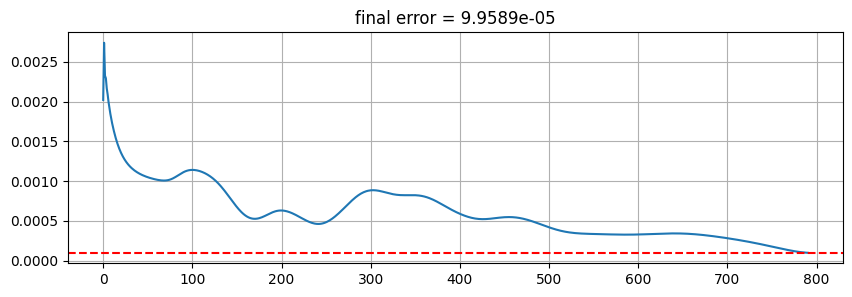

In [19]:
plt.figure(figsize=(10,3))
plt.plot(errors[:])
plt.axhline(ethresh, color="red", linestyle="--")
plt.grid()
plt.title(f"final error = {errors[-1]:5.5g}")

In [20]:
# map staggered variables back to co-located grid
u_final = np.zeros(shape=(NY, NX))
v_final = np.zeros(shape=(NY, NX))
p_final = np.zeros(shape=(NY, NX))
for i in range(NY):
    for j in range(NX):
        # p grid is offset in both directions
        p_final[i, j] = (p[i, j] + p[i + 1, j] + p[i, j + 1] + p[i + 1, j + 1]) / 4
        # u grid is offset in y direction / along i index
        u_final[i, j] = (u[i, j] + u[i + 1, j]) / 2
        # v grid is offsetin x direction / along j index
        v_final[i, j] = (v[i, j] + v[i, j + 1]) / 2

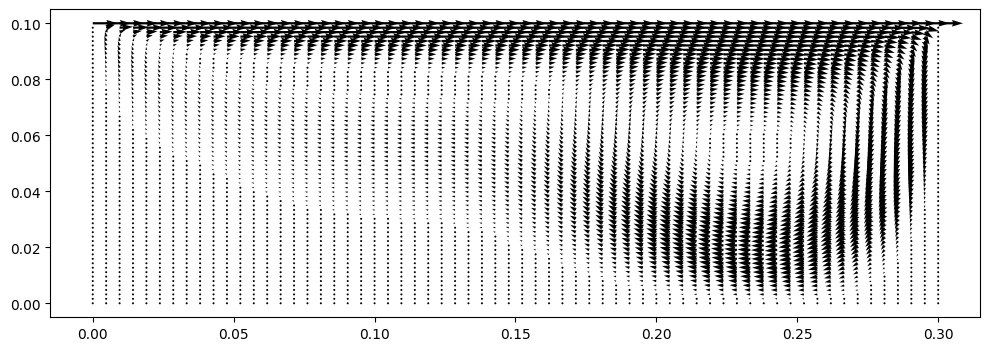

In [28]:
x_grid, y_grid = np.meshgrid(X, LY-Y, indexing="xy")
plt.figure(figsize=(LX*40, LY*40))
plt.quiver(x_grid, y_grid, u_final, v_final, scale=75)

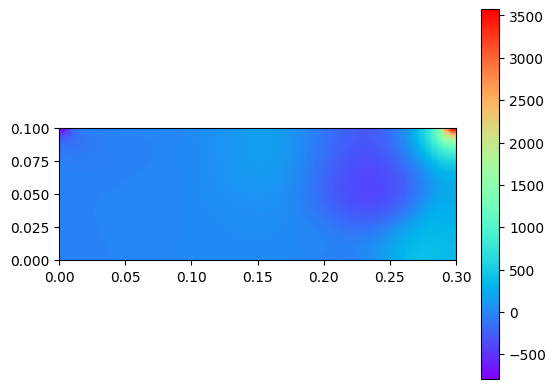

In [22]:
plt.imshow(p_final, extent=(0, LX, 0, LY), cmap="rainbow")
plt.colorbar()